train main one used in the ui

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
Client 1: D Loss = 0.8068, G Loss = 0.7722
Epoch 2/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Client 1: D Loss = 0.7390, G Loss = 0.5829
Epoch 3/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Client 1: D Loss = 0.8304, G Loss = 0.4705
Epoch 4/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Client 1: D Loss = 0.9351, G Loss = 0.3935
Epoch 5/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Client 1: D Loss = 1.0166, G Loss = 0.3394
Epoch 6/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Client 1: D Loss = 1.0842, G Loss = 0.3016
Epoch 7/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Client 1: D Loss = 1.1440, G Loss = 0.2726
Epoch 8/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Client 1: D Loss = 1.1898, G Loss = 0.2488
Epoch 9/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Client 

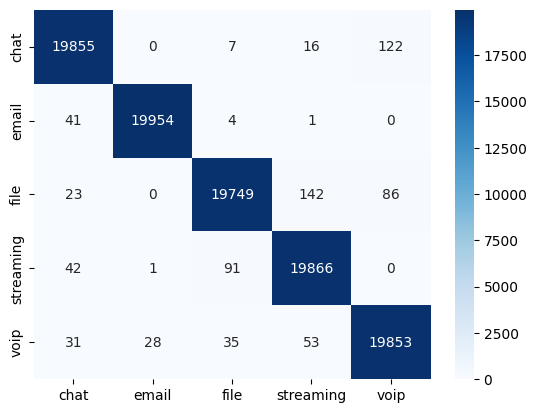

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Save scaler for consistency in testing
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3

# === Generator Model ===
def build_generator():
    model = Sequential([
        Dense(256, input_shape=(LATENT_DIM,), kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(512, kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(X_ISCX.shape[1], activation="tanh")
    ])
    return model

# === Discriminator Model ===
def build_discriminator():
    model = Sequential([
        Dense(512, input_shape=(X_ISCX.shape[1],), kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(256, kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(1, activation="sigmoid")
    ])
    return model

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

# Split dataset among federated clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    # Define GAN model
    gan = Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((half_batch, 1)) * 0.95

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        fake_samples = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1)) + 0.05

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# Train all federated clients
for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# Save Global Generator & Discriminator
client_models[0]["G"].save("models/fgan2_generator.keras")
client_models[0]["D"].save("models/fgan2_discriminator.keras")
print("✅ Saved FGAN-II Generator & Discriminator in .keras format.")

# ==========================
# 🔹 Apply GMM for Pseudo-Labeling
# ==========================
discriminator_features = np.vstack([client_models[0]["D"].predict(client_data[i]) for i in range(NUM_CLIENTS)])

gmm = GaussianMixture(n_components=num_classes, covariance_type='full')
pseudo_labels = gmm.fit_predict(discriminator_features)

# Save GMM Model
joblib.dump(gmm, "models/gmm_model.pkl")
print("✅ Saved GMM model as gmm_model.pkl.")

# Convert pseudo-labels to one-hot encoding
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

# Combine real and pseudo-labels
y_combined = np.concatenate([y_ISCX, pseudo_labels_onehot], axis=0)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Input(shape=input_shape),
    Conv1D(64, 3, activation=LeakyReLU(0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation=LeakyReLU(0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation=LeakyReLU(0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation=LeakyReLU(0.1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

classifier.fit(X_ISCX_reshaped, y_combined, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Save CNN Classifier
classifier.save("models/cnn_classifier.keras")
print("✅ Saved CNN classifier in .keras format.")

# ==========================
# 🔹 Classification Report & Confusion Matrix
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


testing

✅ Models loaded successfully.
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

🔹 Classification Report:
              precision    recall  f1-score   support

        chat       0.99      0.99      0.99     20000
       email       1.00      1.00      1.00     20000
        file       0.99      0.99      0.99     20000
   streaming       0.99      0.99      0.99     20000
        voip       0.99      0.99      0.99     20000

    accuracy                           0.99    100000
   macro avg       0.99      0.99      0.99    100000
weighted avg       0.99      0.99      0.99    100000



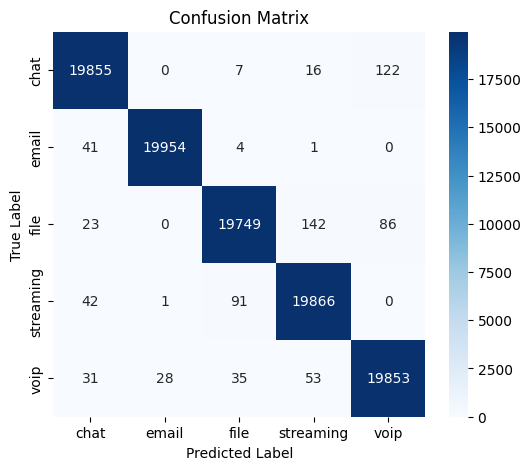

✅ Testing completed.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU

# ==========================
# 🔹 Load Preprocessed Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
DATA_FILE = 'ISCX_5class_each_normalized_cuttedfloefeature.csv'
SCALER_FILE = "models/scaler.pkl"

# Load dataset
df_ISCX = pd.read_csv(DATA_FILE)

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Load saved scaler for consistent transformation
if not os.path.exists(SCALER_FILE):
    raise FileNotFoundError("Scaler file not found. Ensure you have saved it during training.")

scaler = joblib.load(SCALER_FILE)
X_ISCX = scaler.transform(X_ISCX)

# Convert labels to categorical
num_classes = len(LABELS_ISCX)
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# Reshape for CNN input
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

# ==========================
# 🔹 Load Saved Models
# ==========================
try:
    generator = load_model("models/fgan2_generator.keras")
    discriminator = load_model("models/fgan2_discriminator.keras")
    classifier = tf.keras.models.load_model(
        "models/cnn_classifier.keras",
        custom_objects={"LeakyReLU": LeakyReLU}
    )
    gmm = joblib.load("models/gmm_model.pkl")
    print("✅ Models loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading models: {e}")

# ==========================
# 🔹 Generate Fake Samples using Generator
# ==========================
LATENT_DIM = 100
num_samples = X_ISCX.shape[0]

noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
generated_samples = generator.predict(noise, batch_size=128)

# ==========================
# 🔹 Get Discriminator Predictions
# ==========================
discriminator_features = discriminator.predict(X_ISCX, batch_size=128).reshape(-1, 1)

# ==========================
# 🔹 Apply GMM for Pseudo-Labeling
# ==========================
pseudo_labels = gmm.predict(discriminator_features)
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

# Combine real and pseudo labels
y_combined = np.concatenate([y_ISCX, pseudo_labels_onehot], axis=0)

# ==========================
# 🔹 Evaluate CNN Classifier
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped, batch_size=128)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

# Classification Report
print("\n🔹 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("✅ Testing completed.")


trying to reduce the overfittig

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  # KMeans instead of GMM
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import joblib
import os

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# ==========================
# 🔹 Define Simplified FGAN-II Components
# ==========================
LATENT_DIM = 50  # Reduced latent dimension
NUM_CLIENTS = 5  # Reduce number of clients
BATCH_SIZE = 64  # Reduced batch size
EPOCHS = 30  # Reduce training epochs
GENERATOR_UPDATES = 1  # Reduce generator updates per step

# === Generator Model ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(128, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(128, kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0005), metrics=["accuracy"])

# Split dataset among federated clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    # Define GAN model
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0002))

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], BATCH_SIZE // 2)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((BATCH_SIZE // 2, 1)) * 0.9  # One-sided label smoothing

        noise = np.random.normal(0, 1, (BATCH_SIZE // 2, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((BATCH_SIZE // 2, 1)) + np.random.uniform(0, 0.1)  # Label flipping

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# Train all federated clients
for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Deep Embedded Clustering (DEC) with K-Means
# ==========================
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
dec_clusters = kmeans.fit_predict(X_ISCX)

# ==========================
# 🔹 Improved CNN Classifier (Simplified)
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Input(shape=input_shape),
    Conv1D(32, 3, activation=LeakyReLU(0.1), padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 3, activation=LeakyReLU(0.1), padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation=LeakyReLU(0.1), kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

classifier.fit(X_ISCX_reshaped, y_ISCX, epochs=30, batch_size=64, validation_split=0.1,
               callbacks=[early_stopping, reduce_lr])

# Predictions
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_ISCX, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))

# Save CNN Classifier
classifier.save("models/cnn_classifier.keras")
print("✅ Saved CNN classifier in .keras format.")


# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("✅ Testing completed.")

Epoch 1/30 - Training Client 1/5
Client 1: D Loss = 1.0660, G Loss = 0.5144
Epoch 2/30 - Training Client 1/5
Client 1: D Loss = 1.0877, G Loss = 0.4979
Epoch 3/30 - Training Client 1/5
Client 1: D Loss = 1.0761, G Loss = 0.4971
Epoch 4/30 - Training Client 1/5
Client 1: D Loss = 1.0640, G Loss = 0.4917
Epoch 5/30 - Training Client 1/5
Client 1: D Loss = 1.0651, G Loss = 0.4959
Epoch 6/30 - Training Client 1/5
Client 1: D Loss = 1.0531, G Loss = 0.4954
Epoch 7/30 - Training Client 1/5
Client 1: D Loss = 1.0514, G Loss = 0.4929
Epoch 8/30 - Training Client 1/5
Client 1: D Loss = 1.0504, G Loss = 0.4910
Epoch 9/30 - Training Client 1/5
Client 1: D Loss = 1.0461, G Loss = 0.4940
Epoch 10/30 - Training Client 1/5
Client 1: D Loss = 1.0390, G Loss = 0.4980
Epoch 11/30 - Training Client 1/5
Client 1: D Loss = 1.0330, G Loss = 0.5019
Epoch 12/30 - Training Client 1/5
Client 1: D Loss = 1.0293, G Loss = 0.5004
Epoch 13/30 - Training Client 1/5
Client 1: D Loss = 1.0237, G Loss = 0.4964
Epoch 14

🔹 [START] Federated GAN Training
Epoch 1/30 - Training Client 1/5
Epoch 2/30 - Training Client 1/5
Epoch 3/30 - Training Client 1/5
Epoch 4/30 - Training Client 1/5
Epoch 5/30 - Training Client 1/5
Epoch 6/30 - Training Client 1/5
Epoch 7/30 - Training Client 1/5
Epoch 8/30 - Training Client 1/5
Epoch 9/30 - Training Client 1/5
Epoch 10/30 - Training Client 1/5
Epoch 11/30 - Training Client 1/5
Epoch 12/30 - Training Client 1/5
Epoch 13/30 - Training Client 1/5
Epoch 14/30 - Training Client 1/5
Epoch 15/30 - Training Client 1/5
Epoch 16/30 - Training Client 1/5
Epoch 17/30 - Training Client 1/5
Epoch 18/30 - Training Client 1/5
Epoch 19/30 - Training Client 1/5
Epoch 20/30 - Training Client 1/5
Epoch 21/30 - Training Client 1/5
Epoch 22/30 - Training Client 1/5
Epoch 23/30 - Training Client 1/5
Epoch 24/30 - Training Client 1/5
Epoch 25/30 - Training Client 1/5
Epoch 26/30 - Training Client 1/5
Epoch 27/30 - Training Client 1/5
Epoch 28/30 - Training Client 1/5
Epoch 29/30 - Training C

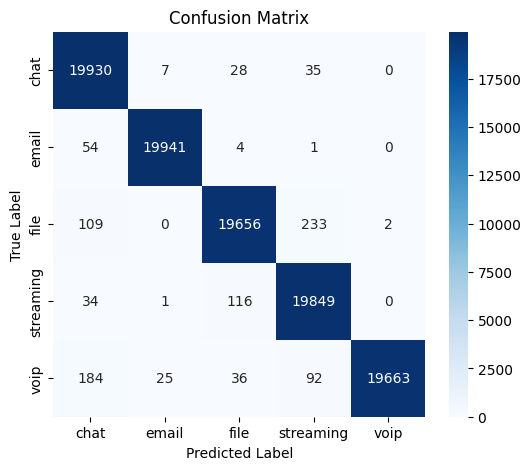

✅ [END] Testing completed.


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  # KMeans instead of GMM
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 50  # Latent dimension
NUM_CLIENTS = 5  # Number of clients
BATCH_SIZE = 64  # Batch size
EPOCHS = 30  # Training epochs
GENERATOR_UPDATES = 1  # Generator updates per step

# === Generator Model ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(128, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(128, kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0005), metrics=["accuracy"])

# Split dataset among federated clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
print("🔹 [START] Federated GAN Training")

def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    # Define GAN model
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0002))

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], BATCH_SIZE // 2)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((BATCH_SIZE // 2, 1)) * 0.9  # One-sided label smoothing

        noise = np.random.normal(0, 1, (BATCH_SIZE // 2, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((BATCH_SIZE // 2, 1)) + np.random.uniform(0, 0.1)  # Label flipping

        discriminator.train_on_batch(real_samples, real_labels)
        discriminator.train_on_batch(generated_samples, fake_labels)

        # Train Generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

# Train all federated clients
for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

print("✅ [END] Federated GAN Training")

# Save GAN models
for idx, client in enumerate(client_models):
    client["G"].save(f"models/FGAN2_Generator_Client{idx+1}.keras")
    client["D"].save(f"models/FGAN2_Discriminator_Client{idx+1}.keras")
print("✅ GAN models exported successfully.")

# ==========================
# 🔹 Deep Embedded Clustering (DEC) with K-Means
# ==========================
print("🔹 [START] DEC Process (K-Means Clustering)")

kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
dec_clusters = kmeans.fit_predict(X_ISCX)

# Save DEC model
joblib.dump(kmeans, "models/DEC_KMeans.pkl")
print("✅ DEC Model (K-Means) saved successfully.")

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
print("🔹 [START] CNN Training")

input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Input(shape=input_shape),
    Conv1D(32, 3, activation=LeakyReLU(0.1), padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 3, activation=LeakyReLU(0.1), padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation=LeakyReLU(0.1), kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

classifier.fit(X_ISCX_reshaped, y_ISCX, epochs=30, batch_size=64, validation_split=0.1,
               callbacks=[early_stopping, reduce_lr])

# Save CNN model
classifier.save("models/cnn_classifier.keras")
print("✅ CNN classifier exported successfully.")

# ==========================
# 🔹 Confusion Matrix & Evaluation
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_ISCX, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("✅ [END] Testing completed.")


testing

🔹 [START] Training Federated GAN-II Models
✅ FGAN-II models trained and saved.
🔹 Generating synthetic data using FGAN-II...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ Synthetic data saved.
🔹 Performing K-Means clustering...
✅ K-Means clustering completed and saved.
🔹 Training CNN Classifier...
Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7434 - loss: 0.9204 - val_accuracy: 0.9876 - val_loss: 0.1706
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9386 - loss: 0.3064 - val_accuracy: 0.9878 - val_loss: 0.1182
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9512 - loss: 0.2265 - val_accuracy: 0.9899 - val_loss: 0.1002
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9566 - loss: 0.1945 - val_accuracy: 0.9893 - val_loss: 0.0898
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9617 - loss: 0.1711 - val_accuracy: 0.9881 - val_loss: 0.0922
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9663 - loss: 0.1562 - val_accuracy: 0.9894 - val_loss: 0.0854
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

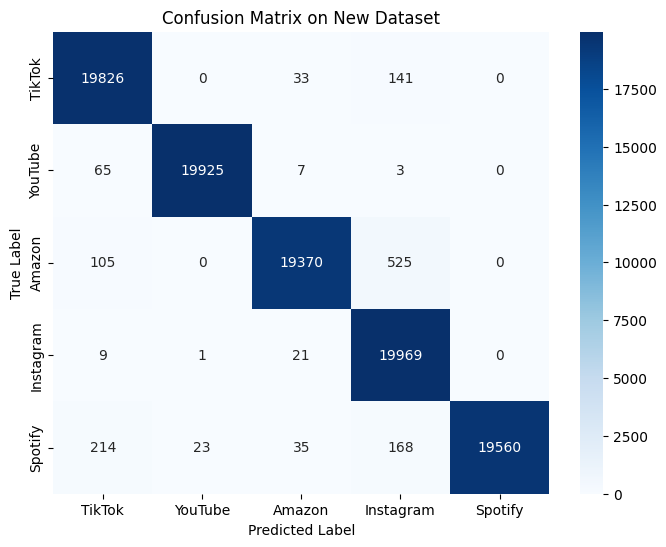

✅ [END] Training and evaluation completed.


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_NEW = ['TikTok', 'YouTube', 'Amazon', 'Instagram', 'Spotify']

# Load dataset
df_new = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_new = df_new.iloc[:, 1:].values  # Exclude index column
Y_new = df_new["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

# Save scaler for future use
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")

# Convert labels to categorical (one-hot encoding)
num_classes_new = len(set(Y_new))
y_new = tf.keras.utils.to_categorical(Y_new, num_classes_new)

# Ensure features are reshaped properly for CNN input
X_new_reshaped = np.expand_dims(X_new, axis=-1)

# ==========================
# 🔹 Define and Train FGAN-II
# ==========================
LATENT_DIM = 50  # Latent dimension
NUM_CLIENTS = 5  # Number of federated clients
BATCH_SIZE = 64  # Training batch size
EPOCHS = 30  # Number of training epochs

# === Generator Model ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(128, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_new.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model ===
def build_discriminator():
    input_d = Input(shape=(X_new.shape[1],))
    x = Dense(128, kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# Create and compile models for each client
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0005), metrics=["accuracy"])

# Split dataset among clients
client_data = np.array_split(X_new, NUM_CLIENTS)

# Train FGAN-II for each client
print("🔹 [START] Training Federated GAN-II Models")
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0002))

    for epoch in range(EPOCHS):
        idx = np.random.randint(0, client_data[client_id].shape[0], BATCH_SIZE // 2)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((BATCH_SIZE // 2, 1)) * 0.9

        noise = np.random.normal(0, 1, (BATCH_SIZE // 2, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((BATCH_SIZE // 2, 1)) + np.random.uniform(0, 0.1)

        discriminator.train_on_batch(real_samples, real_labels)
        discriminator.train_on_batch(generated_samples, fake_labels)

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

# Train each client
for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# Save trained models
for idx, client in enumerate(client_models):
    client["G"].save(f"models/FGAN2_Generator_Client{idx+1}.keras")
    client["D"].save(f"models/FGAN2_Discriminator_Client{idx+1}.keras")
print("✅ FGAN-II models trained and saved.")

# ==========================
# 🔹 Generate Synthetic Data
# ==========================
print("🔹 Generating synthetic data using FGAN-II...")
synthetic_data = []
for i, client in enumerate(client_models):
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    synthetic_samples = client["G"].predict(noise)
    synthetic_data.append(synthetic_samples)
synthetic_data = np.vstack(synthetic_data)
np.save("models/synthetic_data.npy", synthetic_data)
print("✅ Synthetic data saved.")

# ==========================
# 🔹 Apply K-Means Clustering
# ==========================
print("🔹 Performing K-Means clustering...")
kmeans = KMeans(n_clusters=num_classes_new, random_state=42, n_init=10)
dec_clusters = kmeans.fit_predict(X_new)

# Save DEC model
joblib.dump(kmeans, "models/DEC_KMeans.pkl")

# Save dataset with cluster labels
df_new["Cluster_Label"] = dec_clusters
df_new.to_csv("models/new_dataset_with_clusters.csv", index=False)
print("✅ K-Means clustering completed and saved.")

# ==========================
# 🔹 Train CNN Classifier
# ==========================
print("🔹 Training CNN Classifier...")

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

cnn_classifier = Sequential([
    Input(shape=(X_new.shape[1], 1)),
    Conv1D(32, 3, activation=LeakyReLU(0.1), padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(64, 3, activation=LeakyReLU(0.1), padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation=LeakyReLU(0.1), kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(num_classes_new, activation='softmax')
])

cnn_classifier.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_classifier.fit(X_new_reshaped, y_new, epochs=30, batch_size=64, validation_split=0.1)

cnn_classifier.save("models/cnn_classifier.keras")
print("✅ CNN Classifier trained and saved.")

# ==========================
# 🔹 Evaluate CNN Classifier
# ==========================
print("🔹 Evaluating CNN classifier on the new dataset...")
y_pred = cnn_classifier.predict(X_new_reshaped)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_new, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=LABELS_NEW))

# ==========================
# 🔹 Plot Confusion Matrix
# ==========================
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_NEW, yticklabels=LABELS_NEW)
plt.title("Confusion Matrix on New Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("✅ [END] Training and evaluation completed.")


🔹 Loading trained models...
✅ All models loaded successfully.
🔹 Generating synthetic data using FGAN-II...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
✅ Synthetic data generated and saved.
🔹 Performing clustering using K-Means...
✅ Clustering completed and results saved.
🔹 Evaluating CNN classifier on new dataset...
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Confusion Matrix:
 [[  882   102  1866 15124    26]
 [ 1884     3    14 13499  2600]
 [ 4389     1     9 13588    13]
 [  235    36   232 17453    44]
 [  786    21  4780 12372    41]]
Classification Report:
               precision    recall  f1-score   support

      TikTok       0.11      0.05      0.07     18000
     YouTube       0.02      0.00      0.00     18000
      Amazon       0.00      0.00      0.00     18000
   Instagram       0.24      0.97      0.39     18000
     Spoti

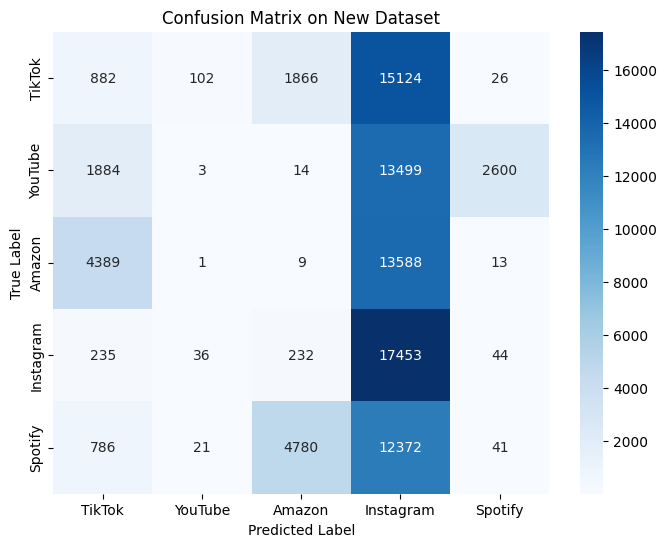

✅ [END] Testing completed.


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import LeakyReLU
# ==========================
# 🔹 Load and Preprocess New Dataset
# ==========================
LABELS_NEW = ['TikTok', 'YouTube', 'Amazon', 'Instagram', 'Spotify']

# Load new dataset
df_test = pd.read_csv('pcapdroid_5class_filtered.csv')  # Replace with actual dataset path

# Extract features and labels
X_test = df_test.iloc[:, 1:].values  # Exclude index column
Y_test = df_test["label"].values  # Extract target labels

# Load the scaler used for training
scaler = joblib.load("models/scaler.pkl")
X_test = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
num_classes_test = len(set(Y_test))
y_test = tf.keras.utils.to_categorical(Y_test, num_classes_test)

# Ensure features are reshaped properly for CNN input
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# ==========================
# 🔹 Load Trained Models
# ==========================
print("🔹 Loading trained models...")

# Load FGAN-II Generators
NUM_CLIENTS = 5
client_models = []
for i in range(NUM_CLIENTS):
    gen = load_model(f"models/FGAN2_Generator_Client{i+1}.keras")
    disc = load_model(f"models/FGAN2_Discriminator_Client{i+1}.keras")
    client_models.append({"G": gen, "D": disc})

# Load K-Means Model
kmeans = joblib.load("models/DEC_KMeans.pkl")

# Load CNN Classifier
classifier = tf.keras.models.load_model(
        "models/cnn_classifier.keras",
        custom_objects={"LeakyReLU": LeakyReLU}
    )

print("✅ All models loaded successfully.")

# ==========================
# 🔹 Generate Synthetic Data Using FGAN-II
# ==========================
print("🔹 Generating synthetic data using FGAN-II...")

LATENT_DIM = 50
BATCH_SIZE = 64
synthetic_data = []

for i, client in enumerate(client_models):
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    synthetic_samples = client["G"].predict(noise)
    synthetic_data.append(synthetic_samples)

synthetic_data = np.vstack(synthetic_data)
np.save("models/synthetic_test_data.npy", synthetic_data)

print("✅ Synthetic data generated and saved.")

# ==========================
# 🔹 Apply K-Means Clustering
# ==========================
print("🔹 Performing clustering using K-Means...")

dec_clusters = kmeans.predict(X_test)

# Save cluster labels to dataframe
df_test["Cluster_Label"] = dec_clusters
df_test.to_csv("models/test_dataset_with_clusters.csv", index=False)

print("✅ Clustering completed and results saved.")

# ==========================
# 🔹 Classification using CNN Model
# ==========================
print("🔹 Evaluating CNN classifier on new dataset...")

y_pred = classifier.predict(X_test_reshaped)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=LABELS_NEW))

# ==========================
# 🔹 Plot Confusion Matrix
# ==========================
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_NEW, yticklabels=LABELS_NEW)
plt.title("Confusion Matrix on New Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("✅ [END] Testing completed.")


trainign on different dataset

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 
Client 1: D Loss = 0.7462, G Loss = 0.4475
Epoch 2/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Client 1: D Loss = 0.7890, G Loss = 0.3360
Epoch 3/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Client 1: D Loss = 0.9080, G Loss = 0.2661
Epoch 4/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Client 1: D Loss = 1.0144, G Loss = 0.2243
Epoch 5/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Client 1: D Loss = 1.1057, G Loss = 0.1947
Epoch 6/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Client 1: D Loss = 1.1892, G Loss = 0.1732
Epoch 7/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Client 1: D Loss = 1.2637, G Loss = 0.1567
Epoch 8/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Client 1: D Loss = 1.3274, G Loss = 0.1432
Epoch 9/50 - Training Client 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Client 

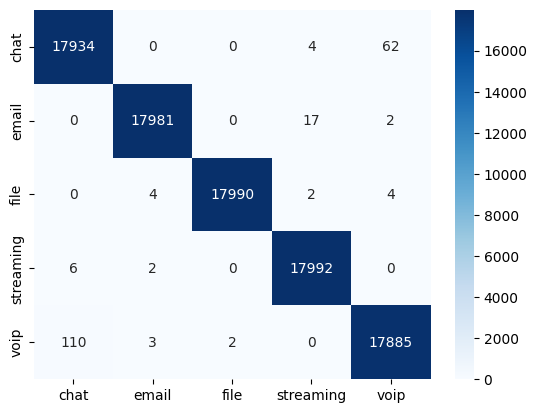

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load dataset
df_ISCX = pd.read_csv('pcapdroid_5class_filtered.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Save scaler for consistency in testing
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scalerp.pkl")

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3

# === Generator Model ===
def build_generator():
    model = Sequential([
        Dense(256, input_shape=(LATENT_DIM,), kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(512, kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(X_ISCX.shape[1], activation="tanh")
    ])
    return model

# === Discriminator Model ===
def build_discriminator():
    model = Sequential([
        Dense(512, input_shape=(X_ISCX.shape[1],), kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(256, kernel_initializer="he_normal"),
        LeakyReLU(alpha=0.2),
        Dense(1, activation="sigmoid")
    ])
    return model

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

# Split dataset among federated clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    # Define GAN model
    gan = Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((half_batch, 1)) * 0.95

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        fake_samples = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1)) + 0.05

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# Train all federated clients
for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# Save Global Generator & Discriminator
client_models[0]["G"].save("models/fgan2_generatorp.keras")
client_models[0]["D"].save("models/fgan2_discriminatorp.keras")
print("✅ Saved FGAN-II Generator & Discriminator in .keras format.")

# ==========================
# 🔹 Apply GMM for Pseudo-Labeling
# ==========================
discriminator_features = np.vstack([client_models[0]["D"].predict(client_data[i]) for i in range(NUM_CLIENTS)])

gmm = GaussianMixture(n_components=num_classes, covariance_type='full')
pseudo_labels = gmm.fit_predict(discriminator_features)

# Save GMM Model
joblib.dump(gmm, "models/gmm_modelp.pkl")
print("✅ Saved GMM model as gmm_model.pkl.")

# Convert pseudo-labels to one-hot encoding
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

# Combine real and pseudo-labels
y_combined = np.concatenate([y_ISCX, pseudo_labels_onehot], axis=0)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Input(shape=input_shape),
    Conv1D(64, 3, activation=LeakyReLU(0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation=LeakyReLU(0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation=LeakyReLU(0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation=LeakyReLU(0.1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

classifier.fit(X_ISCX_reshaped, y_combined, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Save CNN Classifier
classifier.save("models/cnn_classifierp.keras")
print("✅ Saved CNN classifier in .keras format.")

# ==========================
# 🔹 Classification Report & Confusion Matrix
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


✅ Models loaded successfully.
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

🔹 Classification Report:
              precision    recall  f1-score   support

        chat       0.49      0.08      0.14     20000
       email       0.55      0.68      0.61     20000
        file       0.02      0.00      0.01     20000
   streaming       0.44      0.01      0.02     20000
        voip       0.28      0.93      0.43     20000

    accuracy                           0.34    100000
   macro avg       0.35      0.34      0.24    100000
weighted avg       0.35      0.34      0.24    100000



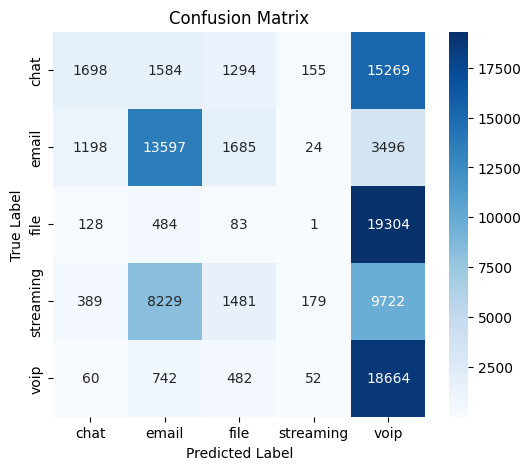

✅ Testing completed.


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU

# ==========================
# 🔹 Load Preprocessed Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
DATA_FILE = 'ISCX_5class_each_normalized_cuttedfloefeature.csv'
SCALER_FILE = "models/scalerp.pkl"

# Load dataset
df_ISCX = pd.read_csv(DATA_FILE)

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Load saved scaler for consistent transformation
if not os.path.exists(SCALER_FILE):
    raise FileNotFoundError("Scaler file not found. Ensure you have saved it during training.")

scaler = joblib.load(SCALER_FILE)
X_ISCX = scaler.transform(X_ISCX)

# Convert labels to categorical
num_classes = len(LABELS_ISCX)
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# Reshape for CNN input
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

# ==========================
# 🔹 Load Saved Models
# ==========================
try:
    generator = load_model("models/fgan2_generatorp.keras")
    discriminator = load_model("models/fgan2_discriminatorp.keras")
    classifier = tf.keras.models.load_model(
        "models/cnn_classifierp.keras",
        custom_objects={"LeakyReLU": LeakyReLU}
    )
    gmm = joblib.load("models/gmm_modelp.pkl")
    print("✅ Models loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading models: {e}")

# ==========================
# 🔹 Generate Fake Samples using Generator
# ==========================
LATENT_DIM = 100
num_samples = X_ISCX.shape[0]

noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
generated_samples = generator.predict(noise, batch_size=128)

# ==========================
# 🔹 Get Discriminator Predictions
# ==========================
discriminator_features = discriminator.predict(X_ISCX, batch_size=128).reshape(-1, 1)

# ==========================
# 🔹 Apply GMM for Pseudo-Labeling
# ==========================
pseudo_labels = gmm.predict(discriminator_features)
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

# Combine real and pseudo labels
y_combined = np.concatenate([y_ISCX, pseudo_labels_onehot], axis=0)

# ==========================
# 🔹 Evaluate CNN Classifier
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped, batch_size=128)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

# Classification Report
print("\n🔹 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("✅ Testing completed.")


trying AECNN


📌 Training Autoencoder...
Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6252 - val_loss: 0.5702
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5680 - val_loss: 0.5679
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5735 - val_loss: 0.5656
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5721 - val_loss: 0.5591
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5862 - val_loss: 0.5581
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5945 - val_loss: 0.5566
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5799 - val_loss: 0.5571
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5663 - val_loss: 0.5567
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5717 - val_loss: 0.5562
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5727 - val_loss: 0.5546
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5666 - val_loss: 0.5544
Epoch 12/50
704/704 ━━━━

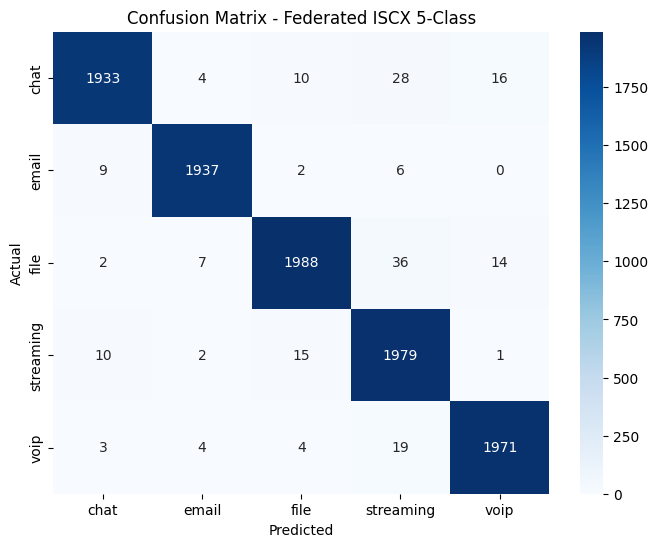

In [4]:
# -*- coding: utf-8 -*-
"""
Federated Learning - ISCX 5-Class Dataset
Feature Extraction using Autoencoder (VAE) + CNN Classification
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
num_classes = len(LABELS_ISCX)

# 🔹 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 🔹 Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 🔹 Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, random_state=5)

# 🔹 Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# 🔹 Define Autoencoder (VAE) for Feature Extraction
latent_dim = 39
input_dim = X_ISCX.shape[1]

# 🔹 Encoder
input_e = Input(shape=(input_dim,))
x = Dense(512, activation="relu")(input_e)
x = Dense(256, activation="relu")(x)
x = Dense(latent_dim, activation="relu")(x)
encoder = Model(input_e, x, name="encoder")

# 🔹 Decoder
input_d = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(input_d)
x = Dense(512, activation="relu")(x)
x = Dense(input_dim, activation="sigmoid")(x)
decoder = Model(input_d, x, name="decoder")

# 🔹 Combine Autoencoder
autoencoder = Model(input_e, decoder(encoder(input_e)))
autoencoder.compile(optimizer="adam", loss="mse")

# 🔹 Train Autoencoder
print("\n📌 Training Autoencoder...")
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test), verbose=1)

# 🔹 Extract Features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# 🔹 Federated Learning Setup
num_clients = 5
client_data_size = len(x_train) // num_clients
client_models = []

# 🔹 Define CNN Classifier
def create_classifier():
    input_c = Input(shape=(latent_dim,))
    x = Dense(128, activation="relu")(input_c)
    x = Dense(64, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = Model(input_c, x, name="CNN_classifier")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# 🔹 Create Global Model
global_model = create_classifier()

# 🔹 Split Data Among Clients
encoded_client_data = np.array_split(x_train_encoded, num_clients)
client_labels = np.array_split(y_train, num_clients)

# 🔹 Train Local Models
for i in range(num_clients):
    print(f"\n📌 Training Client {i+1} Model...")
    local_model = create_classifier()  # 🔹 Ensure each client gets a compiled model
    local_model.set_weights(global_model.get_weights())  # 🔹 Start with global model weights
    local_model.fit(encoded_client_data[i], client_labels[i], epochs=5, batch_size=32, verbose=1)
    client_models.append(local_model)

# 🔹 Federated Averaging (FedAvg)
def fed_avg(models):
    """Perform Federated Averaging"""
    client_weights = [np.array(model.get_weights(), dtype=object) for model in models]
    avg_weights = np.mean(client_weights, axis=0)
    return avg_weights

# 🔹 Update Global Model
global_model.set_weights(fed_avg(client_models))

# 🔹 Evaluate Global Model
y_pred = global_model.predict(x_test_encoded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 🔹 Print Classification Report
print("\n📌 Global Model - Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Federated ISCX 5-Class")
plt.show()



📌 Training Autoencoder...
Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6385 - val_loss: 0.5621
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5757 - val_loss: 0.5537
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5787 - val_loss: 0.5533
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5751 - val_loss: 0.5531
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5544 - val_loss: 0.5517
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5712 - val_loss: 0.5510
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5521 - val_loss: 0.5508
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5757 - val_loss: 0.5511
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5686 - val_loss: 0.5505
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5577 - val_loss: 0.5467
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5785 - val_loss: 0.5464
Epoch 12/50
704/704 ━━━━━

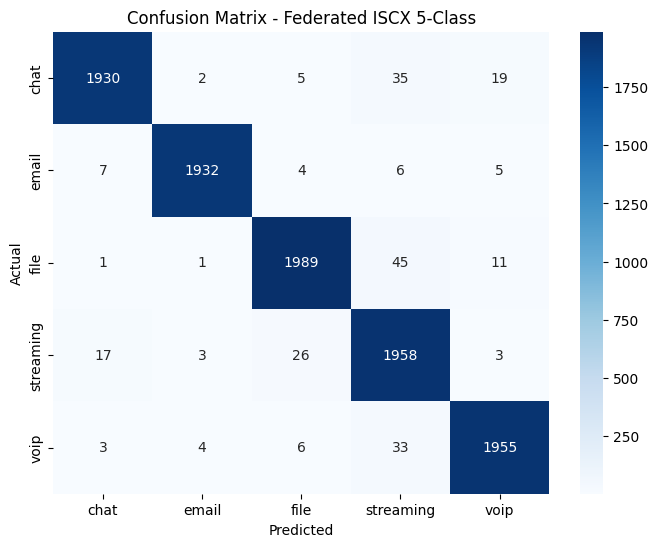

In [5]:
# -*- coding: utf-8 -*-
"""
Federated Learning - ISCX 5-Class Dataset
Feature Extraction using Autoencoder (VAE) + CNN Classification
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
num_classes = len(LABELS_ISCX)

# 🔹 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 🔹 Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 🔹 Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, random_state=5)

# 🔹 Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# 🔹 Define Autoencoder (VAE) for Feature Extraction
latent_dim = 39
input_dim = X_ISCX.shape[1]

# 🔹 Encoder
input_e = Input(shape=(input_dim,))
x = Dense(512, activation="relu")(input_e)
x = Dense(256, activation="relu")(x)
x = Dense(latent_dim, activation="relu")(x)
encoder = Model(input_e, x, name="encoder")

# 🔹 Decoder
input_d = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(input_d)
x = Dense(512, activation="relu")(x)
x = Dense(input_dim, activation="sigmoid")(x)
decoder = Model(input_d, x, name="decoder")

# 🔹 Combine Autoencoder
autoencoder = Model(input_e, decoder(encoder(input_e)))
autoencoder.compile(optimizer="adam", loss="mse")

# 🔹 Train Autoencoder
print("\n📌 Training Autoencoder...")
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test), verbose=1)

# 🔹 Save Autoencoder Models
encoder.save("encoder.keras")
decoder.save("decoder.keras")
autoencoder.save("autoencoder.keras")
print("\n📌 Autoencoder models saved successfully!")

# 🔹 Extract Features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# 🔹 Federated Learning Setup
num_clients = 5
client_data_size = len(x_train) // num_clients
client_models = []

# 🔹 Define CNN Classifier
def create_classifier():
    input_c = Input(shape=(latent_dim,))
    x = Dense(128, activation="relu")(input_c)
    x = Dense(64, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = Model(input_c, x, name="CNN_classifier")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# 🔹 Create Global Model
global_model = create_classifier()

# 🔹 Split Data Among Clients
encoded_client_data = np.array_split(x_train_encoded, num_clients)
client_labels = np.array_split(y_train, num_clients)

# 🔹 Train Local Models
for i in range(num_clients):
    print(f"\n📌 Training Client {i+1} Model...")
    local_model = create_classifier()  # 🔹 Ensure each client gets a compiled model
    local_model.set_weights(global_model.get_weights())  # 🔹 Start with global model weights
    local_model.fit(encoded_client_data[i], client_labels[i], epochs=5, batch_size=32, verbose=1)
    client_models.append(local_model)
    local_model.save(f"client_model_{i+1}.keras")
    print(f"📌 Client {i+1} model saved successfully!")

# 🔹 Federated Averaging (FedAvg)
def fed_avg(models):
    """Perform Federated Averaging"""
    client_weights = [np.array(model.get_weights(), dtype=object) for model in models]
    avg_weights = np.mean(client_weights, axis=0)
    return avg_weights

# 🔹 Update Global Model
global_model.set_weights(fed_avg(client_models))

global_model.save("global_model.keras")
print("\n📌 Global model saved successfully!")

# 🔹 Evaluate Global Model
y_pred = global_model.predict(x_test_encoded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 🔹 Print Classification Report
print("\n📌 Global Model - Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Federated ISCX 5-Class")
plt.show()


test

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

📌 Global Model - Classification Report:
              precision    recall  f1-score   support

        chat       0.08      0.05      0.06     18000
       email       0.19      0.11      0.14     18000
        file       0.08      0.08      0.08     18000
   streaming       0.30      0.73      0.43     18000
        voip       0.68      0.20      0.31     18000

    accuracy                           0.23     90000
   macro avg       0.27      0.23      0.20     90000
weighted avg       0.27      0.23      0.20     90000



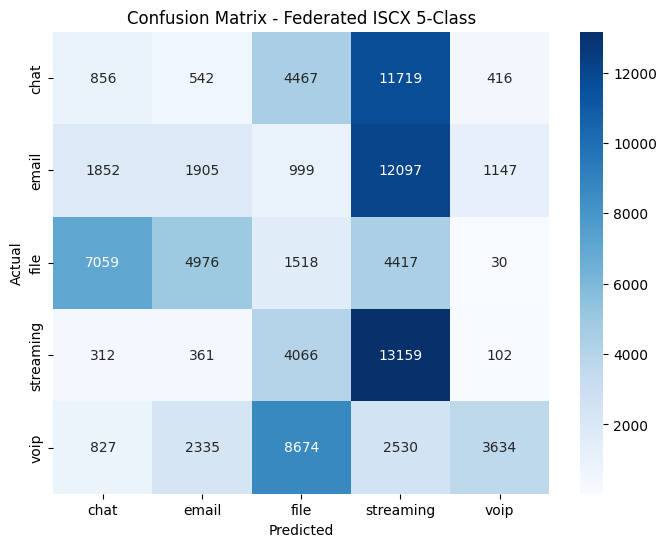

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Load the saved models
encoder = load_model("encoder.keras")
global_model = load_model("global_model.keras")

# 🔹 Load test dataset
df_test = pd.read_csv('pcapdroid_5class_filtered.csv')

# 🔹 Extract features and labels
X_test = df_test.iloc[:, 1:].values  # Exclude first column
Y_test = df_test["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# 🔹 Convert labels to categorical
num_classes = 5  # Assuming 5-class classification
y_test = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

# 🔹 Extract features using encoder
X_test_encoded = encoder.predict(X_test)

# 🔹 Make predictions
y_pred = global_model.predict(X_test_encoded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 🔹 Print Classification Report
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
print("\n📌 Global Model - Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Federated ISCX 5-Class")
plt.show()
